In [41]:
from example.discretizer.utils import IsTrafficLightNearby, StopAreaNearby, FrontObjects, IdleTime, IsTwoWheelNearby, Rotation, Velocity, IsZebraNearby, LanePosition, PedestrianNearby, BlockProgress,NextIntersection
from pgeon.intention_introspector import IntentionIntrospector
from pgeon.desire import Desire
from example.discretizer.discretizer_d0 import AVDiscretizer
from example.discretizer.discretizer_d1 import AVDiscretizerD1
from example.discretizer.discretizer_d2 import AVDiscretizerD2
from sklearn.metrics import auc
import pgeon.policy_graph as PG
from example.environment import SelfDrivingEnvironment
import numpy as np
import matplotlib.pyplot as plt
from typing import Set, Dict, Tuple
import networkx as nx

## Common initialization (valid for each discretiser)

In [42]:
environment = SelfDrivingEnvironment(city='all')
discretizer_configs = {
    'a': {'obj_discretizer': 'binary', 'vel_discretizer': 'binary' },
    'b': {'obj_discretizer': 'multiple', 'vel_discretizer': 'binary'}
    }

default_config = {'obj_discretizer': 'binary', 'vel_discretizer': 'binary'}
commitment_threshold = 0.5

In [43]:


def roc_curve(discretisers_info: Dict[str, Tuple[PG.PolicyGraph, Set[Desire]]]):
    plt.figure(figsize=(10, 6))

    thresholds = np.arange(0, 1, 0.1)
    best_thresholds = {}

    for discretizer_id, (pg, desires) in discretisers_info.items():
        intention_probabilities = []
        expected_probabilities = []
        combined_scores = np.zeros_like(thresholds)

        for i, threshold in enumerate(thresholds):
            ii = IntentionIntrospector(desires, pg)

            intention_prob, expected_prob = ii.get_intention_metrics(commitment_threshold=threshold, desire=any)
            intention_probabilities.append(intention_prob)
            expected_probabilities.append(expected_prob)
            combined_scores[i] = intention_prob + expected_prob

        roc_auc = auc(intention_probabilities, expected_probabilities)
        
        best_index = np.argmax(combined_scores)
        best_threshold = thresholds[best_index]
        best_thresholds[discretizer_id] = best_threshold
        print(f'Discretizer D{discretizer_id} Best Threshold: {best_threshold:.2f}')


        plt.plot(intention_probabilities, expected_probabilities, label=f'Discretizer D{discretizer_id} (AUC = {roc_auc:.2f})')           
                
    plt.xlabel('Intention Probability for any desire')
    plt.ylabel('Expected Intention Probability')
    plt.title('Intention Probability vs Expected Intention Probability for any desire')
    plt.legend()
    plt.grid(True)
    plt.show()

    return best_thresholds



In [44]:
def show_metrics(metrics_data, discretizer_id, type='Desire'):
    
    """
    Function to show bar plots with metrics for each desire. The metrics can be 
    desire or intention metrics, based on the value of the parameter 'type' (Desire or Intention).
    """
    desires = list(metrics_data.keys())

    fig, ax = plt.subplots(figsize=(70, 15))

    labels = []
    val1 = []
    val2 = []

    for desire in desires:
        if desire == 'any':
            val1.append(metrics_data[desire][0])
            val2.append(metrics_data[desire][1])
        else:
            val1.append(metrics_data[desire][0])
            val2.append(metrics_data[desire][1])
        labels.append(f"{desire}")

    x = np.arange(len(desires))
    width = 0.3

    rects1 = ax.bar(x - width/2, val1, width, label=f'{type} Probability')
    metric_label = 'Expected Action Probability' if type == 'Desire' else 'Expected Intention Probability'
    rects2 = ax.bar(x + width/2, val2, width, label=metric_label)

    ax.set_xlabel(f'Desires', fontsize=45)
    ax.set_ylabel(f'{type}s Metrics', fontsize=45)
    ax.set_title(f'Discretizer D{discretizer_id}', fontsize=50)
    ax.set_xticks(x)
    ax.set_xticklabels(labels, fontsize=40,rotation = 30)
    
    plt.yticks(fontsize=30)

        
    ax.legend( fontsize=35, loc='upper right' )
    for rect in rects1:
        height = rect.get_height()
        ax.text(rect.get_x() + rect.get_width() / 2, height, f'{height:.3f}', ha='center', va='bottom', fontsize=35)

    for rect in rects2:
        height = rect.get_height()
        ax.text(rect.get_x() + rect.get_width() / 2, height, f'{height:.3f}', ha='center', va='bottom', fontsize=35)

    plt.show()  
    #plt.savefig(f'{type}_{discretizer_id}.png', bbox_inches = 'tight')

In [45]:
def show_all_metrics_per_desire(desires_data, desire, type='Desire'):

    num_discretizers = len(desires_data)
    
    # Calculate grid size for subplots
    cols = 2  # Number of columns in the grid
    rows = (num_discretizers + 1) // cols  # Calculate rows based on number of discretizers

    fig, axes = plt.subplots(rows, cols, figsize=(10, 5 * rows))
    axes = axes.flatten()  # Flatten the axes array for easy indexing
    
    for i, (discretizer_id, metrics_data) in enumerate(desires_data.items()):
        ax = axes[i]

        if desire not in metrics_data:
            raise ValueError(f"Desire '{desire}' not found in metrics_data for discretizer '{discretizer_id}'.")

        val1 = metrics_data[desire][0]
        val2 = metrics_data[desire][1]
        
        labels = [desire]
        x = np.arange(len(labels))
        width = 0.10

        rects1 = ax.bar(x - width, val1, width, label=f'{type} Probability')
        metric_label = 'Expected Action Probability' if type == 'Desire' else 'Expected Intention Probability'
        rects2 = ax.bar(x + width, val2, width, label=metric_label)

        #ax.set_xlabel('Desire', fontsize=10)
        ax.set_ylabel(f'{type} Metrics', fontsize=10)
        ax.set_title(f'Discretizer D{discretizer_id}', fontsize=12)
        ax.set_xticks(x)
        ax.set_xticklabels(labels)
        ax.set_ylim(0)

        ax.legend(loc='upper left')
        
        for rect in rects1:
            height = rect.get_height()
            ax.text(rect.get_x() + rect.get_width() / 2, height, f'{height:.3f}', ha='center', va='bottom', fontsize=8)

        for rect in rects2:
            height = rect.get_height()
            ax.text(rect.get_x() + rect.get_width() / 2, height, f'{height:.3f}', ha='center', va='bottom', fontsize=8)

    # Hide any unused subplots if the grid is larger than the number of discretizers
    for j in range(i + 1, len(axes)):
        fig.delaxes(axes[j])
    
    plt.tight_layout()
    plt.show()
    #plt.savefig('ciao.png', dpi=200)

#show_all_metrics_per_desire(intentions_data, "any", type='Intention')


'ANY' desire

In [46]:
any = Desire("any", None, set())


Desires Iteration 1

In [47]:
stop_traffic_light = Desire("stop_traffic_light", [1], {IsTrafficLightNearby:  [IsTrafficLightNearby.YES]}) #NOTE: traffic light color can be also green or yellow
stop_stop_sign = Desire("stop_stop_sign", [1], {StopAreaNearby: [StopAreaNearby.STOP]})

stop_zebra = Desire("stop_zebra", [1], {IsZebraNearby: [IsZebraNearby.YES]})
lane_change = Desire("lane_change", [7,8, 2, 3 ], {LanePosition: [LanePosition.CENTER] }) #GAS_TURN_LEFT
turn_at_intersection = Desire("turn_at_intersection", [7,8, 2, 3 ], {BlockProgress: [BlockProgress.INTERSECTION]})
obstacle_avoidance  =Desire("obstacle_avoid", [3,7, 2,8], {FrontObjects: [FrontObjects(1, discretization='binary'), FrontObjects(1, discretization='multiple'), FrontObjects(5, discretization='multiple')]})

desires = [stop_traffic_light, stop_stop_sign, stop_zebra, lane_change, turn_at_intersection, obstacle_avoidance]

Desires Iteration 2

In [95]:
lane_keeping = Desire('lane_keeping', [4,5,6], {LanePosition: [LanePosition.ALIGNED], Rotation: [Rotation.FORWARD], NextIntersection:[NextIntersection.NONE, NextIntersection.STRAIGHT], Velocity: [Velocity.HIGH, Velocity.LOW, Velocity.MEDIUM, Velocity.MOVING]} )
turn_at_intersection = Desire("turn_at_intersection", [2, 3, 7,8,9,10], {BlockProgress: [BlockProgress.INTERSECTION], Rotation: [Rotation.LEFT, Rotation.RIGHT]})
lane_change_to_lf = Desire("lane_change_to_lf", [2,4,5,6,8,10], {Rotation: [Rotation.LEFT],LanePosition: [LanePosition.CENTER], BlockProgress: [BlockProgress.START, BlockProgress.MIDDLE, BlockProgress.END]}) 
lane_change_to_rt = Desire("lane_change_to_rt", [3,4,5,6,7,9], {Rotation: [Rotation.RIGHT],LanePosition: [LanePosition.CENTER], BlockProgress: [BlockProgress.START, BlockProgress.MIDDLE, BlockProgress.END]}) 
lane_change = Desire("lane_change", [4,5,6], {Rotation:[Rotation.FORWARD], LanePosition: [LanePosition.CENTER], BlockProgress:[BlockProgress.START, BlockProgress.MIDDLE, BlockProgress.END]})
#lane change long no very high sicne might mean obstacle aboidance sometimes.

arrive_traffic_light = Desire("arrive_traffic_light", [5, 9, 10], {IsTrafficLightNearby:  [IsTrafficLightNearby.YES], Velocity: [Velocity.MEDIUM, Velocity.HIGH]}) 
wait_traffic_light = Desire("wait_traffic_light", [1], {IsTrafficLightNearby:  [IsTrafficLightNearby.YES], Velocity: [Velocity.STOPPED]})

approach_stop_sign = Desire("approach_stop_sign", [1, 5, 9, 10], {StopAreaNearby: [StopAreaNearby.STOP],Velocity: [Velocity.MEDIUM, Velocity.HIGH, Velocity.LOW, Velocity.MOVING]})
wait_stop_sign = Desire("wait_stop_sign", [1], {StopAreaNearby: [StopAreaNearby.STOP], Velocity: [Velocity.STOPPED], FrontObjects: [FrontObjects(1, 'binary')]}) 
#start_stop_sign = Desire('start_stop_sign', [4, 7,8], {IsTrafficLightNearby:[IsTrafficLightNearby.NO],NextIntersection: [NextIntersection.STRAIGHT, NextIntersection.LEFT, NextIntersection.RIGHT], StopAreaNearby: [StopAreaNearby.STOP], Velocity: [Velocity.STOPPED], FrontObjects: [FrontObjects(0, discretization='binary')], PedestrianNearby: [PedestrianNearby(0, discretization='binary')]})
start_stop_sign_time = Desire('start_stop_sign_time', [4,7,8], { NextIntersection: [NextIntersection.STRAIGHT, NextIntersection.LEFT, NextIntersection.RIGHT],IdleTime: [IdleTime('4'), IdleTime('5+')], StopAreaNearby: [StopAreaNearby.STOP], Velocity: [Velocity.STOPPED], FrontObjects: [FrontObjects(0, discretization='binary')], PedestrianNearby: [PedestrianNearby(0, discretization='binary')]})
#reason: Adverse Weather Conditions: If the scene involves poor weather conditions (rain, fog, snow), the vehicle might behave more conservatively, leading to a longer stop.
#NOTE: experiment if this happens with good scenes or bad scenes.
#NOTE: se metton FrontObjects(YES) invece di NO mi da come risultato 0 intention probability, che è giusto
yield_to_vehicles = Desire("yield_to_vehicles", [1, 5, 9, 10], {BlockProgress: [BlockProgress.END, BlockProgress.INTERSECTION], StopAreaNearby: [StopAreaNearby.YIELD, StopAreaNearby.TURN_STOP], Rotation: [Rotation.LEFT, Rotation.RIGHT], FrontObjects: [FrontObjects(1, 'binary')], NextIntersection:[NextIntersection.RIGHT, NextIntersection.NONE, NextIntersection.LEFT]})
yield_to_peds = Desire("yield_to_peds", [1,5, 9, 10], {IsZebraNearby:[IsZebraNearby.YES],BlockProgress: [BlockProgress.END, BlockProgress.INTERSECTION],StopAreaNearby: [StopAreaNearby.YIELD, StopAreaNearby.TURN_STOP], Rotation: [Rotation.LEFT, Rotation.RIGHT], PedestrianNearby:[PedestrianNearby(1,'binary')], NextIntersection:[NextIntersection.RIGHT, NextIntersection.NONE, NextIntersection.LEFT]})
 


peds_at_zebra_crossing_high_speed= Desire("peds_at_zebra_crossing_high_speed", [5, 9, 10], {IsZebraNearby: [IsZebraNearby.YES],Velocity:[ Velocity.MEDIUM,Velocity.HIGH], PedestrianNearby: [PedestrianNearby(1, discretization='binary')]}) #i do not always  stop as some time they already started crossing
peds_at_zebra_crossing_low_speed= Desire("peds_at_zebra_crossing_low_speed", [1,5,9,10], {IsZebraNearby: [IsZebraNearby.YES],Velocity:[ Velocity.LOW], PedestrianNearby: [PedestrianNearby(1, discretization='binary')]}) #i do not always  stop as some time they already started crossing

#(non penso piu sia per questio)low because  we also consider pedestrians on walkaway. should add predicate to distinguid between on street and on walkway pedestrians
#low because the car stops to let pds pass, but restarts before they finished crossing, so of course pedsnearby is still flagged to YES.

two_wheel_presence = Desire('two_wheel_presence', [5,9,10], {IsTwoWheelNearby: [IsTwoWheelNearby.YES], Velocity: [Velocity.HIGH]})
#TODO: Maybe because cycles are on walkway? explain why you do not put idle among the actions, since there are no velocity.low in the desirable state.

jaywalk_response = Desire('Jaywalk Response', [1,2,3,5,9,10], {PedestrianNearby:[PedestrianNearby(1, 'binary')], IsZebraNearby: [IsZebraNearby.NO],  Velocity:[Velocity.HIGH, Velocity.MEDIUM, Velocity.LOW, Velocity.MOVING]})
#low because maybe captures ppl on walkaway. check with real scenes.



lf_obstacle_avoidance  =Desire("Avoid Left Obstacle", [3,7,9], {Rotation: [Rotation.RIGHT], LanePosition: [ LanePosition.ALIGNED], FrontObjects: [FrontObjects(1, discretization='binary')], NextIntersection: [NextIntersection.NONE, NextIntersection.LEFT, NextIntersection.STRAIGHT]})
rt_obstacle_avoidance  =Desire("Avoid Right Obstacle", [2,8,10], {Rotation: [Rotation.LEFT], LanePosition: [ LanePosition.ALIGNED], FrontObjects: [FrontObjects(1, discretization='binary')], NextIntersection: [NextIntersection.NONE, NextIntersection.RIGHT, NextIntersection.STRAIGHT]})


desires =[lane_keeping, approach_stop_sign, wait_stop_sign, start_stop_sign_time, arrive_traffic_light, wait_traffic_light, yield_to_peds,yield_to_vehicles, peds_at_zebra_crossing_high_speed,peds_at_zebra_crossing_low_speed, jaywalk_response, two_wheel_presence, turn_at_intersection, lane_change, lf_obstacle_avoidance,rt_obstacle_avoidance ]
desires = [lf_obstacle_avoidance,rt_obstacle_avoidance]

Evil Desires

In [81]:
no_jaywalk_response = Desire('No Jaywalk Response', [4,6,7,8], {PedestrianNearby:[PedestrianNearby(1, 'binary')], IsZebraNearby: [IsZebraNearby.NO],  Velocity: [Velocity.HIGH, Velocity.MEDIUM]})
no_yield_to_vehicles = Desire("no_yield_to_vehicles", [2,3,4,6,7,8], {BlockProgress: [BlockProgress.END, BlockProgress.INTERSECTION],StopAreaNearby: [StopAreaNearby.YIELD, StopAreaNearby.TURN_STOP], Rotation: [Rotation.LEFT, Rotation.RIGHT], FrontObjects: [FrontObjects(1, 'binary')], NextIntersection:[NextIntersection.RIGHT, NextIntersection.NONE, NextIntersection.LEFT]})
no_yield_to_peds = Desire("no_yield_to_peds", [2,3,4,6,7,8], {BlockProgress: [BlockProgress.END,  BlockProgress.INTERSECTION],StopAreaNearby: [StopAreaNearby.YIELD, StopAreaNearby.TURN_STOP], Rotation: [Rotation.LEFT, Rotation.RIGHT], PedestrianNearby:[PedestrianNearby(1,'binary')], NextIntersection:[NextIntersection.RIGHT, NextIntersection.NONE, NextIntersection.LEFT]})
no_peds_at_zebra_crossing_high = Desire("no_peds_at_zebra_crossing_high", [4,6,7,8], {IsZebraNearby: [IsZebraNearby.YES], Velocity:[ Velocity.MEDIUM,Velocity.HIGH], PedestrianNearby: [PedestrianNearby(1, discretization='binary')]}) #i do not always want to stop as some time they already started crossing
#no_peds_at_zebra_crossing_turn= Desire("no_peds_at_zebra_crossing_turn", [2,3,7,8], {IsZebraNearby: [IsZebraNearby.YES], Velocity:[ Velocity.LOW], PedestrianNearby: [PedestrianNearby(1, discretization='binary')]}) #i do not always want to stop as some time they already started crossing
no_peds_at_zebra_crossing_low = Desire("no_peds_at_zebra_crossing_low", [4,6,7,8], {IsZebraNearby: [IsZebraNearby.YES], Velocity:[ Velocity.LOW], PedestrianNearby: [PedestrianNearby(1, discretization='binary')]}) #i do not always want to stop as some time they already started crossing
no_two_wheel_presence = Desire('no_two_wheel_presence', [2,3,4,7,8], {IsTwoWheelNearby: [IsTwoWheelNearby.YES], Velocity: [Velocity.HIGH]})
no_approach_stop_sign = Desire("no_approach_stop_sign", [2,3,4,6,7,8], {StopAreaNearby: [StopAreaNearby.STOP], Velocity: [Velocity.HIGH, Velocity.MEDIUM, Velocity.LOW, Velocity.MOVING]})#, FrontObjects:[FrontObjects(0,'binary')], PedestrianNearby:[PedestrianNearby(0,'binary')] }) #are there 
#maybe because the orientation of stop sign is wrong (it refers to another road)
no_driving_area = Desire("no_driving_area", [1,2,3,4,5,6,7,8,9,10], {BlockProgress: [BlockProgress.NONE]})
no_safe_distance = Desire("no_safe_distance",  [4,7,8], {FrontObjects: {FrontObjects(1, 'binary')}, Velocity: {Velocity.HIGH}}) #REMINDER: we are in urban sccenerio, not in highway

desires = [no_jaywalk_response,no_yield_to_vehicles, no_yield_to_peds,no_peds_at_zebra_crossing_low,no_peds_at_zebra_crossing_high,no_two_wheel_presence,no_approach_stop_sign,no_driving_area,no_safe_distance]


## Discretisers 0a, 0b, 1a, 1b

#### Compute Desires and Intention Metrics


In [94]:

intentions_data = {}
desires_data = {}

for discretizer_id in ['2b']:#,'0a','0b', '1a','1b']:
    config = default_config
    for key in discretizer_configs:
        if key in discretizer_id:
            config = discretizer_configs[key]
            break


    DiscretizerClass = AVDiscretizer if '0' in discretizer_id else AVDiscretizerD1 if '1' in discretizer_id else AVDiscretizerD2

    discretizer = DiscretizerClass(
            environment,
            vel_discretization=config['vel_discretizer'],
            obj_discretization=config['obj_discretizer'],
            id=discretizer_id
        ) 
    nodes_path = f'example/dataset/data/policy_graphs_10/PG_trainval_Call_D{discretizer_id}_Wall_Tall_nodes.csv'
    edges_path = f'example/dataset/data/policy_graphs_10/PG_trainval_Call_D{discretizer_id}_Wall_Tall_edges.csv'
    print(f'DISCRETIZER {discretizer_id} ')
    pg = PG.PolicyGraph.from_nodes_and_edges(nodes_path, edges_path, environment, discretizer)
    
    weakly_connected_components = list(nx.weakly_connected_components(pg))
    for component in weakly_connected_components:
        if len(component) == 1:
            pg.remove_node(next(iter(component))) 

    
    

    ii = IntentionIntrospector(desires, pg)
    desires_data[discretizer_id] = ii.find_desires() 
    print(desires_data[discretizer_id])
    intentions_data[discretizer_id] = ii.find_intentions( commitment_threshold) #{desire.name: [self.get_intention_metrics(commitment_threshold, desire)] for desire in self.desires}
    intentions_data[discretizer_id]['any']=ii.get_intention_metrics(commitment_threshold,any)
    print(intentions_data[discretizer_id])
    print()

DISCRETIZER 2b 
{'Avoid Left Obstacle': (0.031063536325747355, 0.5747284910277991), 'Avoid Right Obstacle': (0.027495427423465564, 0.6608724329252745)}
{'Avoid Left Obstacle': (0.019879463884141402, 0.8811363804858404), 'Avoid Right Obstacle': (0.019339749932535753, 0.9036766195253881), 'any': (0.03921921381667716, 0.8922514066177274)}



### QA Examples

In [12]:
ii.question6(lane_keeping,list(pg.nodes())[10])


How do you plan to fulfill lane_keeping from state (IdleTime(0), PedestrianNearby(NO), IsTwoWheelNearby(NO), BlockProgress(START), LanePosition(ALIGNED), NextIntersection(NONE), Velocity(LOW), Rotation(RIGHT), StopAreaNearby(NO), IsZebraNearby(NO), IsTrafficLightNearby(NO), FrontObjects(YES))?
[[<Action.BRAKE: 5>], (IdleTime(0), PedestrianNearby(NO), IsTwoWheelNearby(NO), BlockProgress(MIDDLE), LanePosition(ALIGNED), NextIntersection(NONE), Velocity(LOW), Rotation(FORWARD), StopAreaNearby(NO), IsZebraNearby(NO), IsTrafficLightNearby(NO), FrontObjects(YES)), <Action.GAS: 4>, <Action.BRAKE: 5>, <Action.STRAIGHT: 6>]


In [13]:
ii.question6(lane_keeping,list(pg.nodes())[0])


How do you plan to fulfill lane_keeping from state (IdleTime(0), PedestrianNearby(NO), IsTwoWheelNearby(NO), BlockProgress(INTERSECTION), LanePosition(ALIGNED), NextIntersection(NONE), Velocity(LOW), Rotation(RIGHT), StopAreaNearby(TURN_STOP), IsZebraNearby(YES), IsTrafficLightNearby(YES), FrontObjects(NO))?
From such state there is not path to fulfill the desire.


### Bar Plot

#### Desires

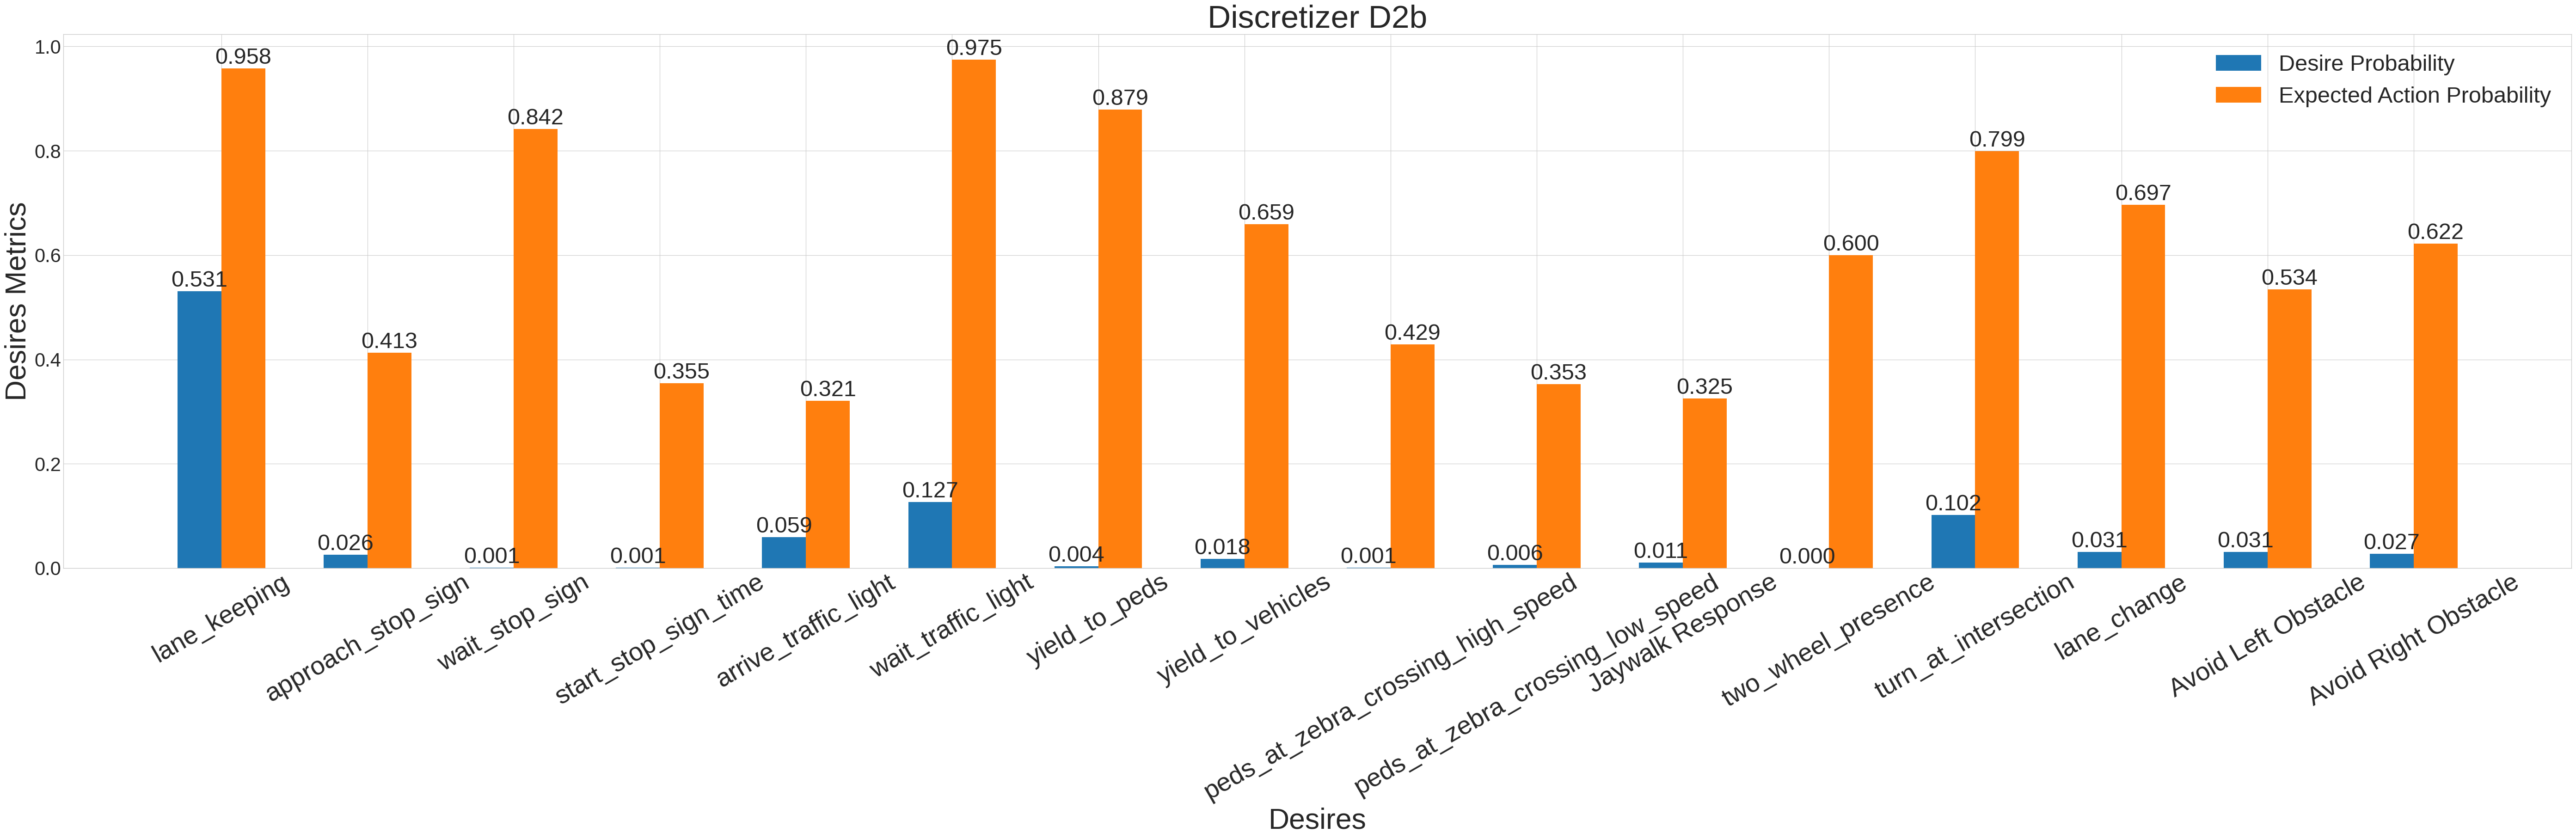

In [50]:
for discretizer in desires_data.keys():
    show_metrics(desires_data[discretizer], discretizer, type = 'Desire')


Reasons for apprach stop sign: maybe the predicate doesnt capture well the stop sign (i.e. the rectangle gets stop signs from other roads). To investigate, i check the desire approach stop sign without objects/peds in front. if the values are the same, it means maybe that the car doesnt stop at the sign because there is no other road user.

#### Intentions

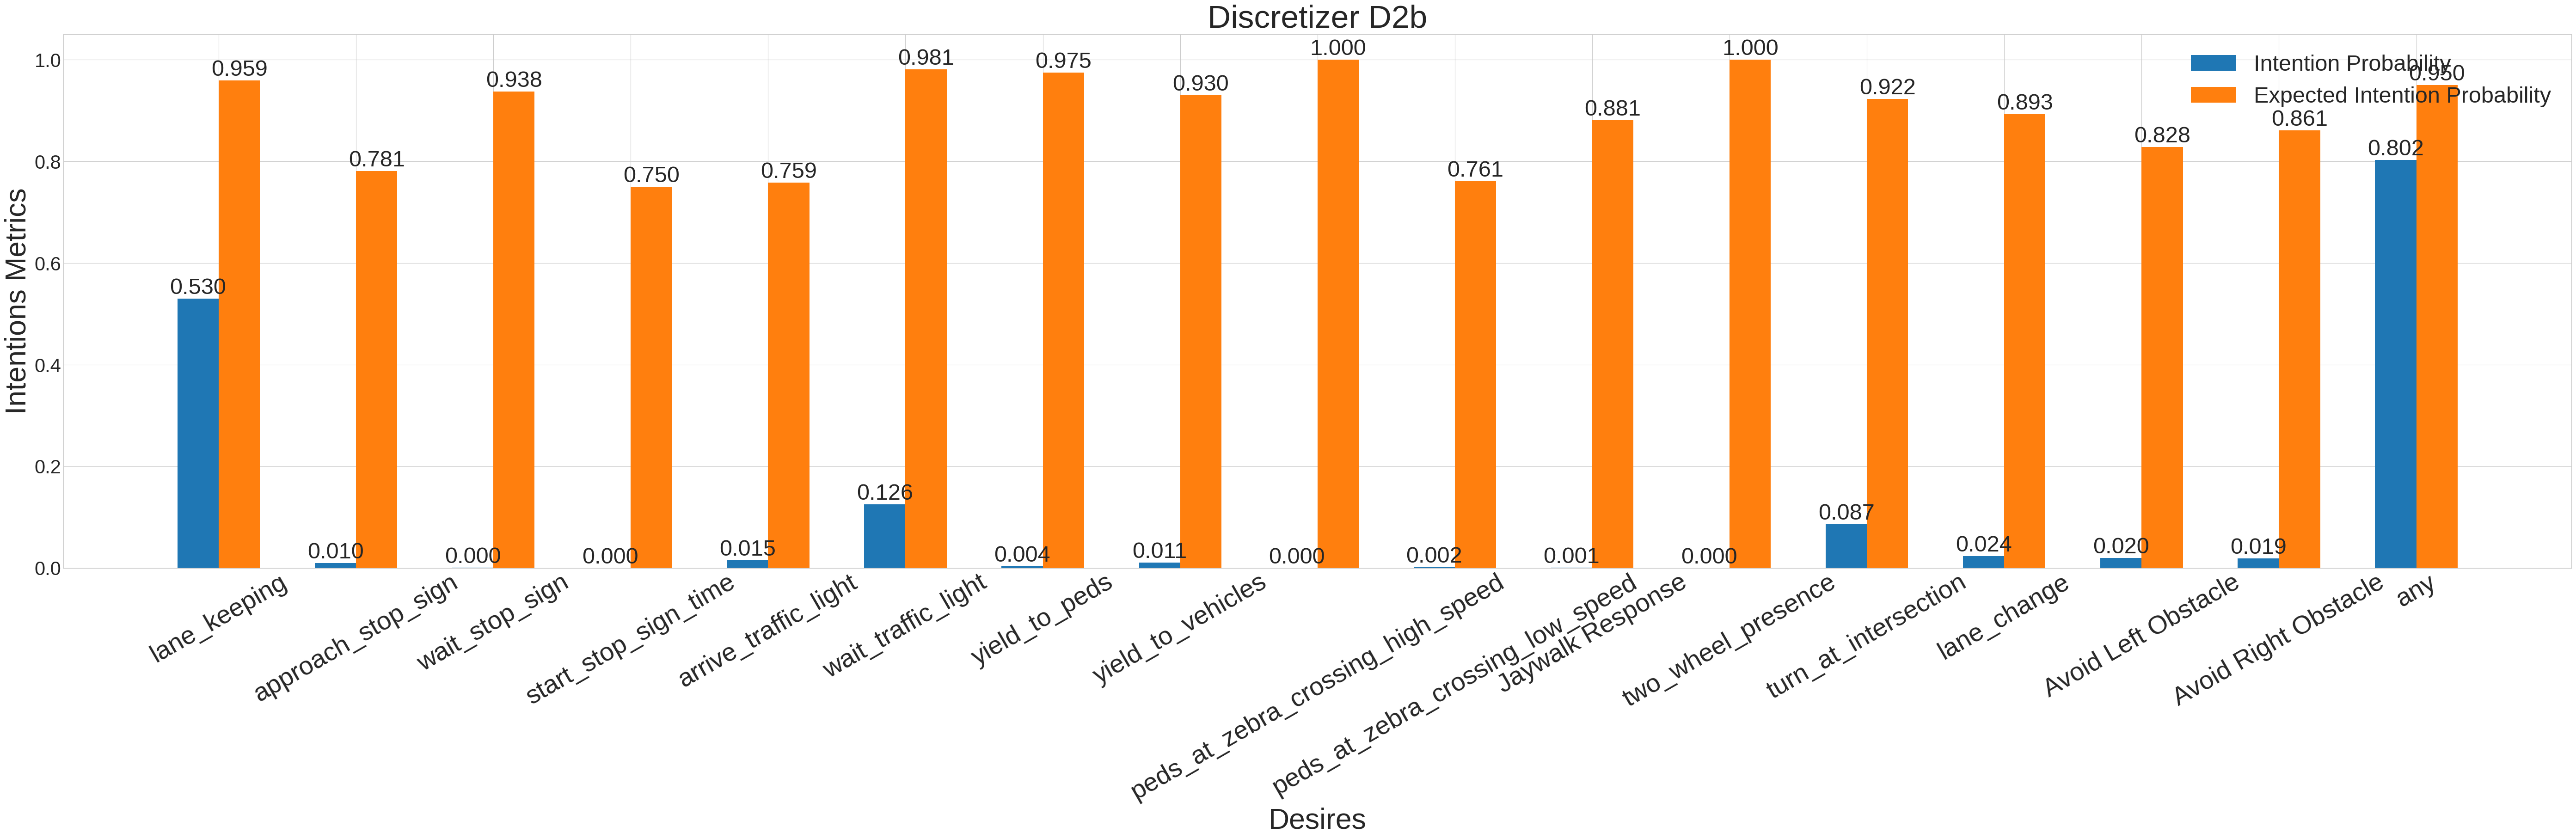

In [61]:
for discretizer in intentions_data.keys():
    show_metrics(intentions_data[discretizer], discretizer, type = 'Intention')

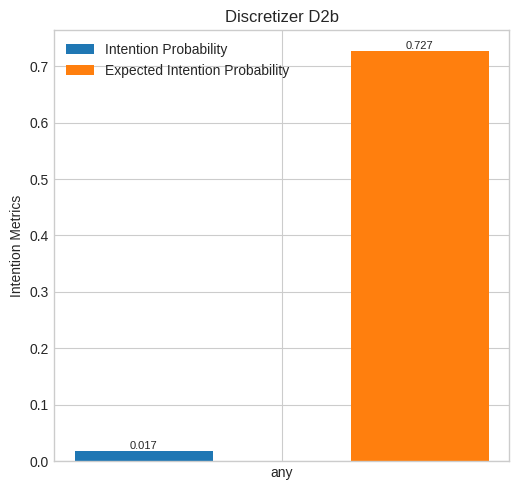

In [49]:
show_all_metrics_per_desire(intentions_data, "any", type='Intention')


### ROC Curve


Choose the discretiser with higher AIC, that is, the discretiser where the interpretability vs reliability trade-off is better

- If there is no commitment threshold in which the two metrics are decently high, it becomes apparent that the desires do not capture the agent’s behaviour. This can be either because the agent did not train correctly (making the hypothesised desires something it cannot reach) or because the agent is targeting a different set of desires. Our case is the latter. 

- The probability of manifesting intentions is low. the behaviour is not interpretable with these desires, and new ones should be considered.


After seeing seeing this, we added new desires related to OBSTACLE AVOIDANCE, which improved the AUC  for discretisers D0b and D0c.

In [17]:
discretizers_info = {}
for discretizer_id in ['2b','0a','0b', '1a', '1b']:
    config = default_config
    for key in discretizer_configs:
        if key in discretizer_id:
            config = discretizer_configs[key]
            break

    DiscretizerClass = AVDiscretizer if '0' in discretizer_id else AVDiscretizerD1 if '1' in discretizer_id else AVDiscretizerD2
    discretizer = DiscretizerClass(
            environment,
            vel_discretization=config['vel_discretizer'],
            obj_discretization=config['obj_discretizer'],
            id=discretizer_id
            ) 
    nodes_path = f'example/dataset/data/policy_graphs/PG_trainval_Call_D{discretizer_id}_Wall_Tall_nodes.csv'
    edges_path = f'example/dataset/data/policy_graphs/PG_trainval_Call_D{discretizer_id}_Wall_Tall_edges.csv'
    pg = PG.PolicyGraph.from_nodes_and_edges(nodes_path, edges_path, environment, discretizer)
    
    discretizers_info[discretizer_id] = (pg, desires)


FileNotFoundError: [Errno 2] No such file or directory: 'example/dataset/data/policy_graphs/PG_trainval_Call_D2b_Wall_Tall_nodes.csv'

In [ ]:
#roc_curve(discretizers_info)

### TEST ON 1 SCENE

Example scenes: 
- jaywalking: 93036f2be8de445aad06b727b848cea5,  9709626638f5406f9f773348150d02fd ,
many intentions:
- 724957e51f464a9aa64a16458443786d
stop at red light to let pedestrians cross:
- 1977a1c98a6c4eb79fbc2a6dc0da9b0f

In [111]:
import pandas as pd
intentions_data = {}
desires_data = {}
discretizer_id = '2b'
scene_token = '01452fbfbf4543af8acdfd3e8a1ee806' #'1aa633b683174280b243e0a9a7ad9171'
city ="boston-seaport"
env = SelfDrivingEnvironment(city)
disc = AVDiscretizerD2(env, vel_discretization='multiple',id=discretizer_id)
pg = PG.PolicyGraph(env, disc)
dtype_dict = {
        'modality': 'category',  # for limited set of modalities, 'category' is efficient
        'scene_token': 'str',  
        'steering_angle': 'float64', 
        'rain': 'int',
        'night':'int',
        'location': 'str',
        'timestamp': 'str',  # To enable datetime operations
        'rotation': 'object',  # Quaternion (lists)
        'x': 'float64',
        'y': 'float64',
        'z': 'float64',
        'yaw': 'float64',  
        'velocity': 'float64',
        'acceleration': 'float64',
        'yaw_rate': 'float64'
    }
df = pd.read_csv('/home/saramontese/Desktop/MasterThesis/example/dataset/data/sets/nuscenes/full_v1.0-trainval_lidar_1_10.csv', dtype=dtype_dict, parse_dates=['timestamp'])
df = df[df['location'] == city]
df = df[df['scene_token']==scene_token]
pg = pg.fit(df, update=False, verbose=True)
    

ii = IntentionIntrospector(desires, pg)

desires_data[discretizer_id] = ii.find_desires() 
print(desires_data[discretizer_id])
intentions_data[discretizer_id] = ii.find_intentions( commitment_threshold)
intentions_data[discretizer_id]['any']=ii.get_intention_metrics(commitment_threshold,any)
print(intentions_data[discretizer_id])
print()

Fitting PG from scenes...:   0%|          | 0/1 [00:00<?, ?it/s]

scene token: 01452fbfbf4543af8acdfd3e8a1ee806


Fitting PG from scenes...: 100%|██████████| 1/1 [00:06<00:00,  6.52s/it]

frame 0 --> [IdleTime(0), PedestrianNearby(NO), IsTwoWheelNearby(NO), BlockProgress(END), LanePosition(ALIGNED), NextIntersection(STRAIGHT), Velocity(STOPPED), Rotation(RIGHT), StopAreaNearby(NO), IsZebraNearby(NO), IsTrafficLightNearby(YES), FrontObjects(YES)]
action: Action.IDLE
frame 1 --> [IdleTime(4), PedestrianNearby(NO), IsTwoWheelNearby(NO), BlockProgress(END), LanePosition(ALIGNED), NextIntersection(STRAIGHT), Velocity(STOPPED), Rotation(RIGHT), StopAreaNearby(NO), IsZebraNearby(NO), IsTrafficLightNearby(YES), FrontObjects(YES)]
action: Action.IDLE
frame 2 --> [IdleTime(4), PedestrianNearby(NO), IsTwoWheelNearby(NO), BlockProgress(END), LanePosition(ALIGNED), NextIntersection(STRAIGHT), Velocity(STOPPED), Rotation(RIGHT), StopAreaNearby(NO), IsZebraNearby(NO), IsTrafficLightNearby(YES), FrontObjects(YES)]
action: Action.IDLE
frame 3 --> [IdleTime(4), PedestrianNearby(NO), IsTwoWheelNearby(NO), BlockProgress(END), LanePosition(ALIGNED), NextIntersection(STRAIGHT), Velocity(STOP

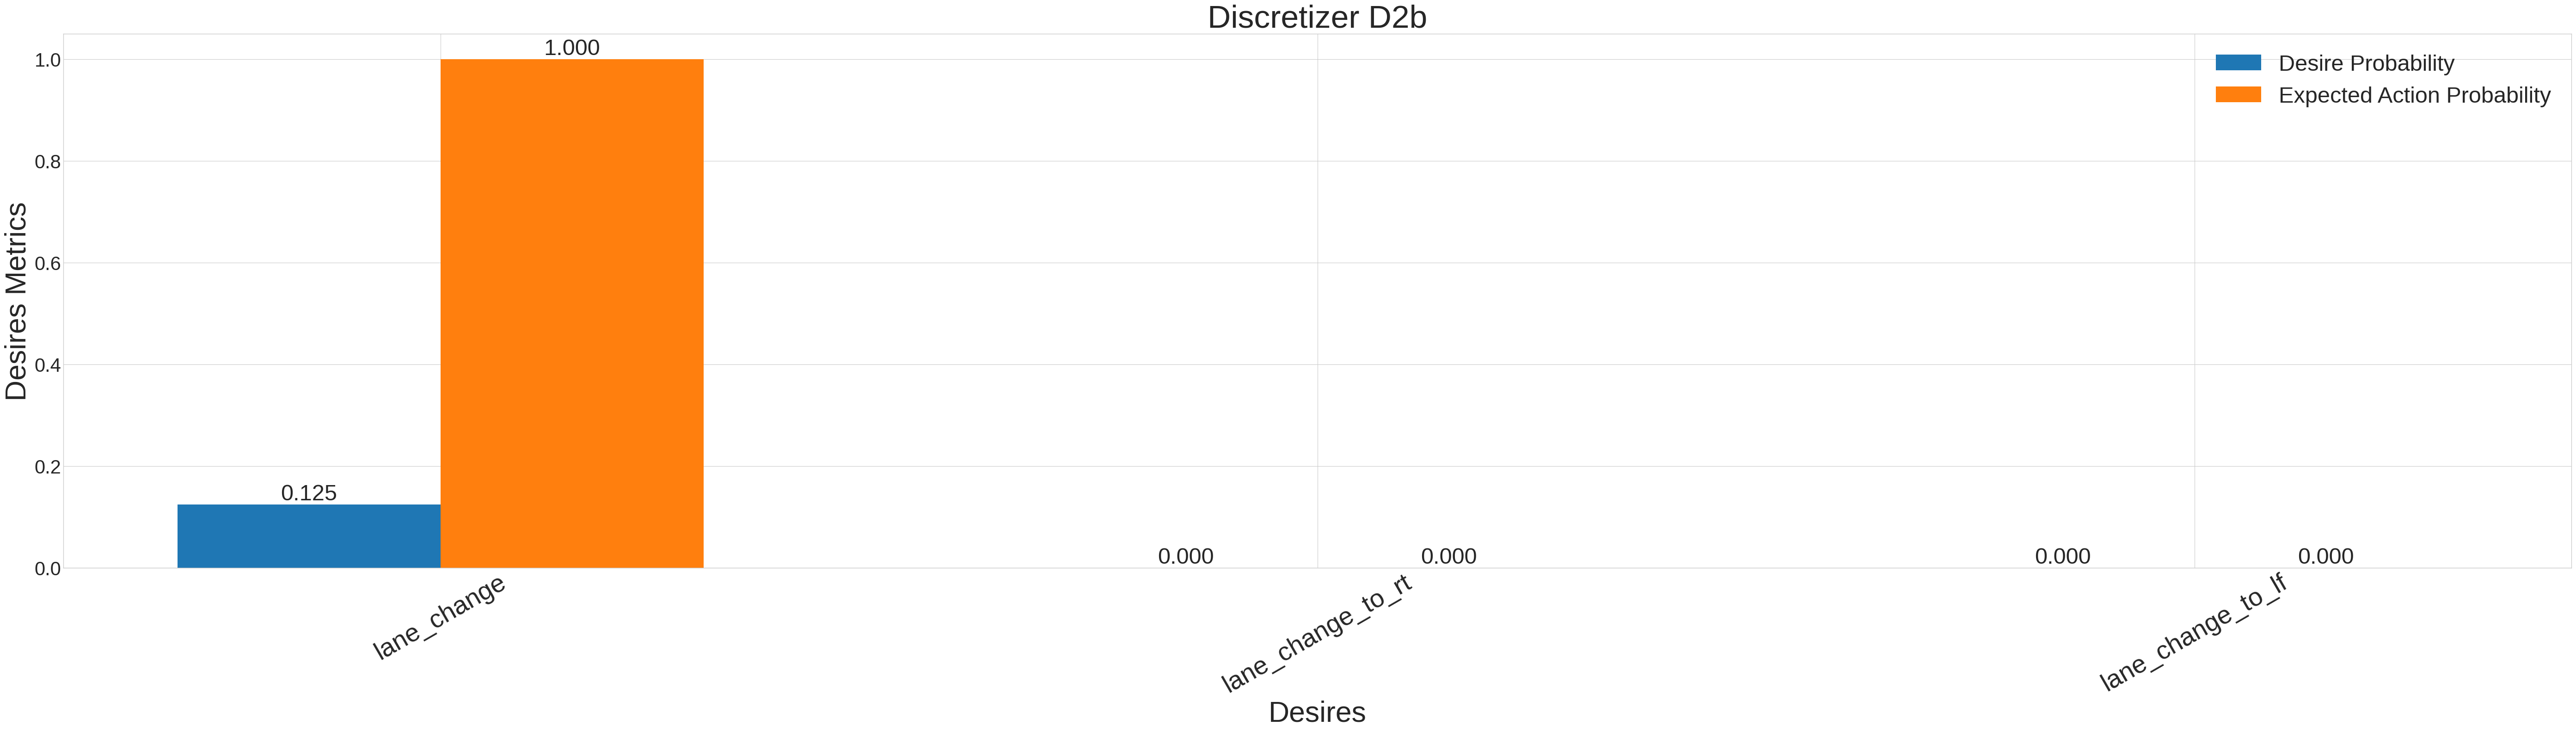

In [112]:
for discretizer in desires_data.keys():
    show_metrics(desires_data[discretizer], discretizer, type = 'Desire')


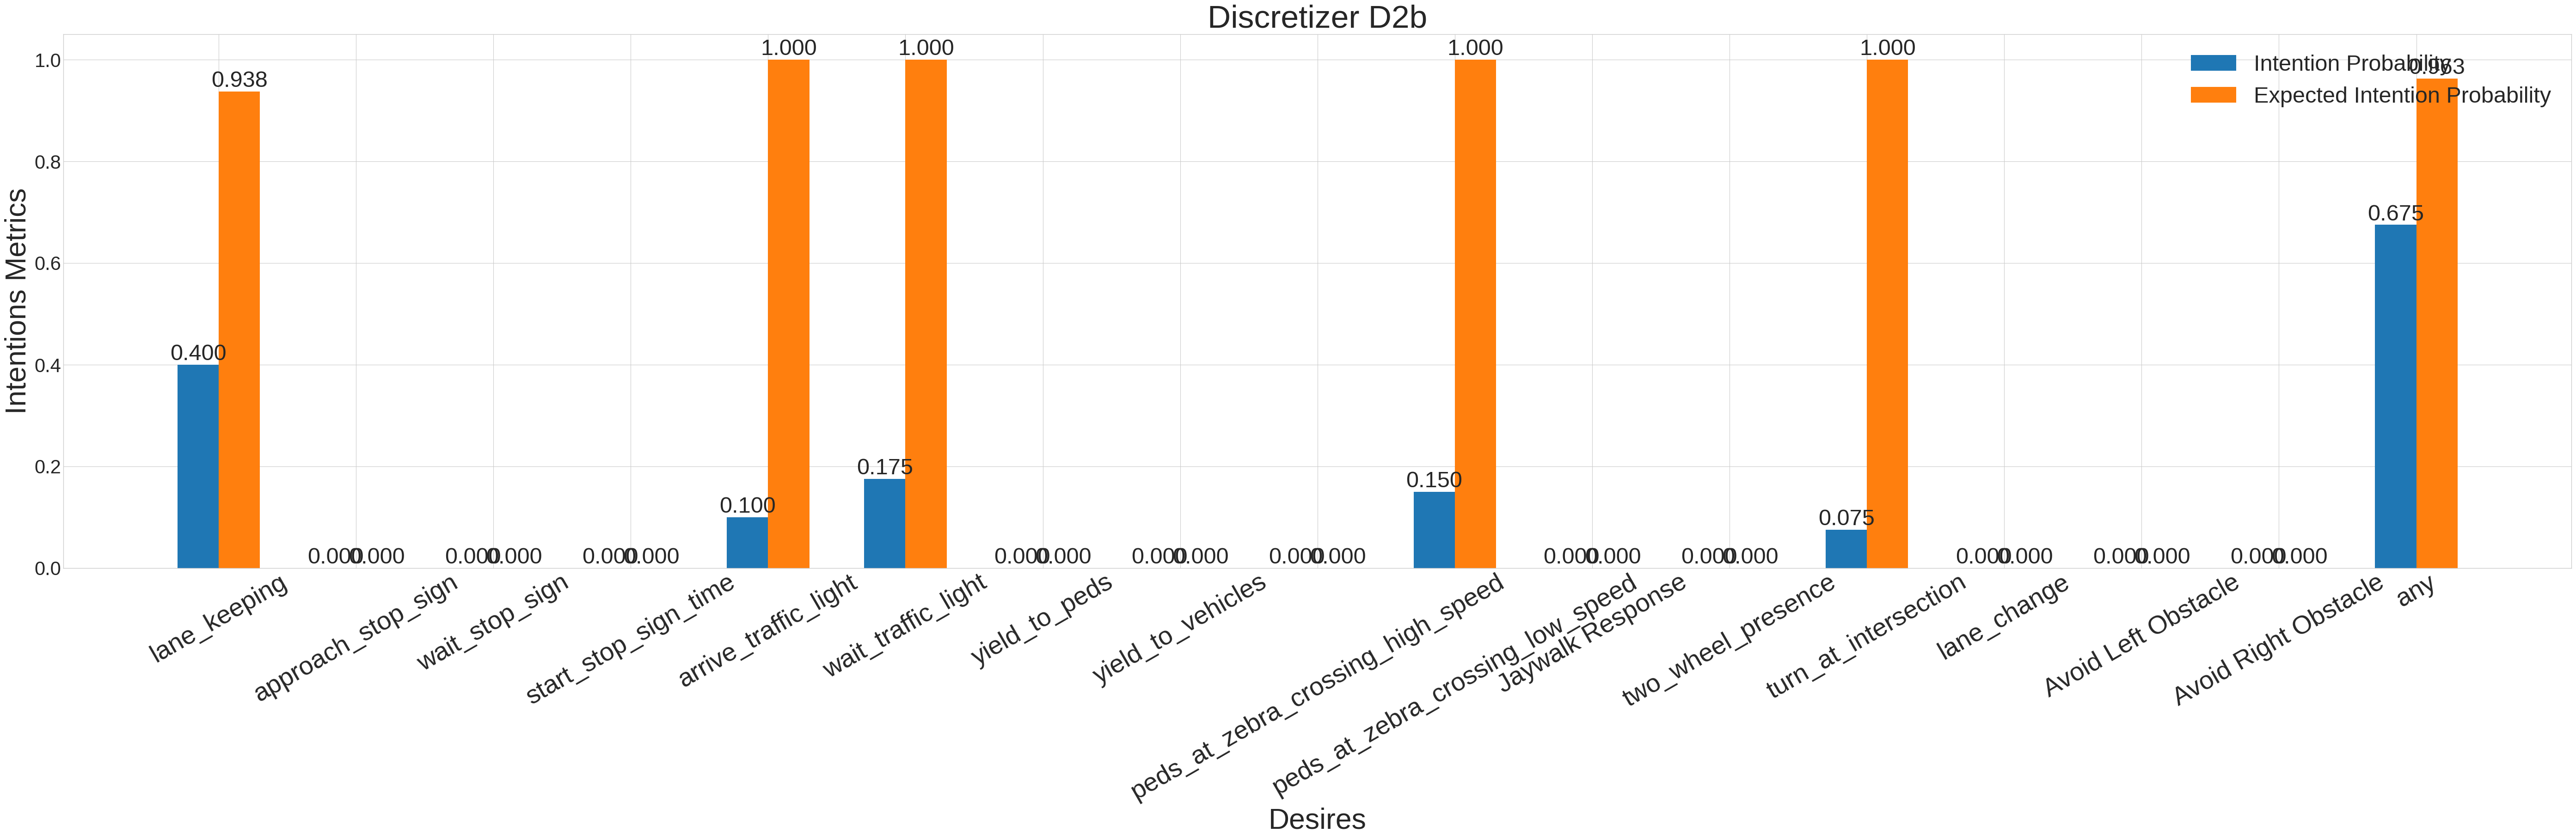

In [81]:
for discretizer in intentions_data.keys():
    show_metrics(intentions_data[discretizer], discretizer, type = 'Intention')

comment:
- no intention of slowing down when getting close to pedestrians (highlights bad behavior indeed)

#### QUESTIONS

In [ ]:
ii.question6(lf_obstacle_avoidance,list(pg.nodes())[9])


How do you plan to fulfill Avoid Left Obstacle from state (IdleTime(0), PedestrianNearby(NO), IsTwoWheelNearby(NO), BlockProgress(START), LanePosition(ALIGNED), NextIntersection(NONE), Velocity(LOW), Rotation(LEFT), StopAreaNearby(TURN_STOP), IsZebraNearby(NO), IsTrafficLightNearby(NO), FrontObjects(NO))?
From such state there is not path to fulfill the desire.
